In [4]:
# Version 2 of LSTM model, will be more precise than before
from itertools import combinations
import os
import sys
import time
from typing import Optional
from unicodedata import bidirectional

from imblearn.over_sampling import SMOTE
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras._tf_keras.keras.metrics import MeanAbsoluteError, Accuracy, Precision, Recall, MeanSquaredError
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences 
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Masking, InputLayer
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import skew, kurtosis
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [5]:

def create_dataframe_from_data(input_path: str):
    data_frames = []
    landmark_cols = []
    landmark_world_cols = [] 
    gesture_index = 0 

    for file_name in os.listdir(input_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_path, file_name)

            dataframe = pd.read_csv(file_path)

            # Gathers the landmark column names
            if(len(landmark_cols) == 0 and len(landmark_world_cols) == 0):
                landmark_cols = [col for col in dataframe.columns if col.startswith(("x", "y", "z"))]
                landmark_world_cols = [col for col in dataframe.columns if col.startswith(("wx", "wy", "wz"))]
            
            gesture = file_name.split("_")[0]
            gesture_index = int(file_name.split("_")[1].split(".")[0])

            dataframe["gesture"] = gesture
            dataframe["gesture_index"] = gesture_index

            dataframe.sort_values(by="frame", inplace=True)

            data_frames.append(dataframe)

    if len(data_frames) == 0:
        raise ValueError("Dataframe has no data")
    else:
        return pd.concat(data_frames, ignore_index=True), landmark_cols, landmark_world_cols

def split_dataset(dataframe: pd.DataFrame, label_col: str, train_ratio=0.6 , val_ratio=0.2, test_ratio=0.2):
    
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."
    
    train_frames = []
    val_frames = []
    test_frames = []

    for _, gesture_data in dataframe.groupby("gesture_index"):
        n_frames = len(gesture_data)
        n_train = int(n_frames * train_ratio)
        n_val = int(n_frames * val_ratio)

        train_split = gesture_data.iloc[:n_train]
        val_split = gesture_data.iloc[n_train:n_train + n_val]
        test_split = gesture_data.iloc[n_train + n_val:]

        train_frames.append(train_split)
        val_frames.append(val_split)
        test_frames.append(test_split)
    
    train_set = pd.concat(train_frames).reset_index(drop=True)
    val_set = pd.concat(val_frames).reset_index(drop=True)
    test_set = pd.concat(test_frames).reset_index(drop=True)

    # Separate X and y
    X_train = train_set.drop(columns=[label_col])
    y_train = train_set[[label_col, "frame", "gesture_index"]]
    X_val = val_set.drop(columns=[label_col])
    y_val = val_set[[label_col, "frame", "gesture_index"]]
    X_test = test_set.drop(columns=[label_col])
    y_test = test_set[[label_col, "frame", "gesture_index"]]

    return X_train, y_train, X_val, y_val, X_test, y_test

def calculate_elapsed_time(df: pd.DataFrame):

    elapsed_lists = []

    for _, gesture_data in df.groupby("gesture_index"):
        avg_frame_rate = np.mean(gesture_data["frame_rate"])

        for i in gesture_data["frame"]:
            elapsed_lists.append(i / avg_frame_rate)
        
    df['elapsed_time'] = elapsed_lists

    return df

def calculate_temporal_features(df: pd.DataFrame, cols: list):
    velocity_cols = [f"velocity_{col}" for col in cols]
    acceleration_cols = [f"acceleration_{col}" for col in cols]
    jerk_cols = [f"jerk_{col}" for col in cols]
    
    for _, gesture_data in df.groupby("gesture_index"): 
        gesture_data = gesture_data.sort_values(by="frame")

        avg_frame_rate = np.mean(gesture_data["frame_rate"])
        time_diffs = gesture_data["frame"].diff().fillna(1) / avg_frame_rate
        
        velocities = gesture_data[cols].diff().div(time_diffs, axis=0).fillna(0)
        accelerations = velocities.diff().div(time_diffs, axis=0).fillna(0)
        jerks = accelerations.diff().div(time_diffs, axis=0).fillna(0)

        df.loc[gesture_data.index, velocity_cols] = velocities.values
        df.loc[gesture_data.index, acceleration_cols] = accelerations.values
        df.loc[gesture_data.index, jerk_cols] = jerks.values

    return df
  
def calculate_temporal_stats(df: pd.DataFrame, cols: list):
    mean_cols = [f"mean_{col}" for col in cols]
    var_cols = [f"variance_{col}" for col in cols] 
    dev_cols = [f"deviation_{col}" for col in cols] 
    skew_cols = [f"skew_{col}" for col in cols] 
    kurt_cols = [f"kurt_{col}" for col in cols] 

    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")

        df.loc[gesture_data.index, dev_cols] = gesture_data[cols].rolling(2).std(engine="cython").values # might convert these to numpy for better efificeny in the future
        df.loc[gesture_data.index, var_cols] = gesture_data[cols].rolling(2).var(engine="cython").values
        df.loc[gesture_data.index, skew_cols] = gesture_data[cols].rolling(6).skew().values
        df.loc[gesture_data.index, kurt_cols] = gesture_data[cols].rolling(6).kurt().values
        df.loc[gesture_data.index, mean_cols] = gesture_data[cols].expanding().mean(engine="cython").values

    return df

def calculate_landmark_distances(df: pd.DataFrame, cols: list):
    distance_columns = [f"lm_distance_{i}_{j}" for i in range(len(cols)//3) for j in range(len(cols)//3)]

    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")
        
        coords = gesture_data[cols].values.reshape(-1, len(cols) // 3, 3)
        distances = np.sqrt(np.sum((coords[:, :, None] - coords[:, None, :])**2, axis=-1))
        
        # we technically should do something called zero out - basically in the df x_0/x_1 == x_1/x_0 (redundant)

        distances_flat = distances.reshape(-1, len(distance_columns))
        df.loc[gesture_data.index, distance_columns] = distances_flat

    return df

def calculate_landmark_angles(df: pd.DataFrame, cols: list):
    angles_per_gesture_list = []
    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")
        gesture_points = gesture_data[cols]
        angles_for_gesture = []

        
        # Iterate over each pair of consecutive points
        for i in range(len(gesture_points) - 1):
            point_a = gesture_points.iloc[i]
            point_b = gesture_points.iloc[i + 1]

            angles = []
            
            # Iterate over each landmark
            for j in range(21):
                idx = j  # Adjust if cols include additional information beyond x, y, z (e.g., wx, wy, wz)
                
                # Extract coordinates for point_a and point_b
                ax, ay, az = point_a[f"x_{idx}"], point_a[f"y_{idx}"], point_a[f"z_{idx}"]
                bx, by, bz = point_b[f"x_{idx}"], point_b[f"y_{idx}"], point_b[f"z_{idx}"]

                # Calculate dot product
                dot_prod = ax * bx + ay * by + az * bz

                # Calculate magnitudes
                magnitude1 = np.linalg.norm([ax, ay, az])
                magnitude2 = np.linalg.norm([bx, by, bz])

                # Calculate angle in degrees
                if magnitude1 > 0 and magnitude2 > 0:
                    angle = np.arccos(np.clip(dot_prod / (magnitude1 * magnitude2), -1.0, 1.0)) * (180 / np.pi)
                else:
                    angle = 0.0  # Handle division by zero or near-zero magnitude cases

                angles.append(angle)

            angles_for_gesture.append(angles)

        angles_per_gesture_list.extend(angles_for_gesture) 

    # Create DataFrame with angles_per_gesture_list
    angles_cols = [f"angle_{n1}" for n1 in range(21)]
    angles_per_gesture_list.insert(0, [0.0] * len(angles_cols))
    angles_df = pd.DataFrame(angles_per_gesture_list, columns=angles_cols)
    # Append angles_df to df
    df = pd.concat([df, angles_df], axis=1)

    return df

def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list):
    """
    List of features
        Elasped time - time of the the recorded gesture since frame 0 ✅
        velocity ✅
        acceleration ✅
        jerk ✅
        pairwise distances ✅
        landmark angles ✅
        gesture_stats - mean, variance, skewness, and kurtosis ✅

        process time
            elapsed_time_fuc - 0.15625
            temporal - 6.671875
            stats - 24.1875
            landmarks - 85.421875 -> 32.203125 (more like 60 if running all functions)
            angles - 4.265625

        problems to hand - skew, kurt, and variance have null values - because of the lack of fillna. Skew and kurt are bigger problems cuz of rolling (will use interpolation for this and others)
        distance is just not being calculated  ✅
    """
    df_copy = df.copy()

    s = time.process_time()
    df_elapsed = calculate_elapsed_time(df_copy)    
    print(time.process_time()-s)


    s = time.process_time()
    df_temporal = calculate_temporal_features(df_copy, landmark_cols)
    print(time.process_time()-s)
    
    s = time.process_time()
    df_stats = calculate_temporal_stats(df_copy, landmark_cols)
    print(time.process_time()-s)


    s = time.process_time()
    df_pairwise = calculate_landmark_distances(df_copy, landmark_cols)
    print(time.process_time()-s)


    s = time.process_time()
    df_angle = calculate_landmark_angles(df_copy, landmark_cols)
    print(time.process_time()-s)
   
    
    s = time.process_time()
    df_combined = pd.concat([df_copy, df_angle], axis=1)
    print(time.process_time()-s)
    
    # Ensure there are no duplicate columns
    df_combined = df_combined.loc[:,~df_combined.columns.duplicated()]
    return df_combined

def reshape_y_labels(df: pd.DataFrame):
    unique_sequences = []
    for _, group in df.groupby("gesture_index"):
        reset_points = group['frame'].diff().fillna(1) < 0
        if reset_points.any():
            unique_sequences.append(group[reset_points])
        else:
            # If no reset points, consider the whole group as unique
            unique_sequences.append(group.iloc[[0]])

    # Concatenate unique sequences
    df_unique = pd.concat(unique_sequences).reset_index(drop=True)
    return df_unique["gesture"]



def preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', MinMaxScaler())
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        ("normalize", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=-1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

def print_shapes(X_train, X_val, X_test, y_train = None, y_val = None, y_test = None):
    print(f"X shapes: {X_train.shape}||{X_val.shape}||{X_test.shape}")
    if y_train is not None and y_val is not None and y_test is not None:
        print(f"y shapes: {y_train.shape} || {y_val.shape} || {y_test.shape}")

def find_longest_continuous_chain(df: pd.DataFrame):
    gesture_index_cols = df.columns[df.columns.str.startswith("cat__gesture_index_")]

    longest_length = 0 
    target_gesture_index = None 

    for col in gesture_index_cols:
        gesture_index = col.split("_")[-1]
        gesture_data = df[col].values 

        # Use NumPy to find the lengths of continuous sequences of 1s
        padded = np.pad(gesture_data, (1, 1), constant_values=0)
        diff = np.diff(padded)
        start_indices = np.where(diff == 1)[0]
        end_indices = np.where(diff == -1)[0]
        lengths = end_indices - start_indices
        
        max_length = lengths.max() if lengths.size > 0 else 0

        if max_length > longest_length:
            longest_length = max_length
            target_gesture_index = gesture_index

    return [longest_length, target_gesture_index]
    
def pad_dataframe(df: pd.DataFrame): 
    frame_list = find_longest_continuous_chain(df.copy())

    cols_to_pad = [col for col in df.columns if col.startswith("cat__gesture_index_") and col != frame_list[1]]
    num_of_cols = [col for col in df.columns if col.startswith("cat__gesture_index_")]

    columns = df.columns
    data = df.values 
    for col in cols_to_pad:
        col_index = df.columns.get_loc(col)
        num_frames = int(df[col].sum())
        frames_diff = frame_list[0] - num_frames

        if frames_diff > 0: 
            gesture_index_rows = np.where(data[:, col_index] == 1)[0]
            last_frame_index = gesture_index_rows[-1]
            
            # Create padding array with -1 values for all columns except the current col
            padding_data = np.full((frames_diff, data.shape[1]), -1)
            padding_data[:, col_index] = -1
            
            # Insert padding rows after the last frame of the current gesture
            data = np.insert(data, last_frame_index + 1, padding_data, axis=0)

    # Convert the NumPy array back to a DataFrame
    padded_df = pd.DataFrame(data, columns=columns)
    # padded_df.to_csv(f"model\\LSTM\\v2\\{frame_list[1]}_{time.time()}.csv", index=False)
    return padded_df.to_numpy(), frame_list[0], len(num_of_cols), len(df.columns.values.tolist())


imported
X shapes: (6372, 1235)||(2087, 1235)||(2246, 1235)
y shapes: (6372, 3) || (2087, 3) || (2246, 3)
X shapes: (135, 111, 1235)||(135, 37, 1235)||(135, 38, 1235)
y shapes: (135,) || (135,) || (135,)
(135, 111, 1235)
Epoch 1/200


c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.2223 - loss: 2.1542 - val_accuracy: 0.1630 - val_loss: 1.8083 - learning_rate: 0.0100
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2677 - loss: 1.7733 - val_accuracy: 0.2370 - val_loss: 1.5613 - learning_rate: 0.0100
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3449 - loss: 1.5759 - val_accuracy: 0.5111 - val_loss: 1.4487 - learning_rate: 0.0100
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3602 - loss: 1.5535 - val_accuracy: 0.5778 - val_loss: 1.3750 - learning_rate: 0.0100
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4238 - loss: 1.4177 - val_accuracy: 0.6667 - val_loss: 1.2336 - learning_rate: 0.0100
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5120 - loss: 1.2560 - val_accuracy: 0.7407 - val_loss: 1.1649 - learning_rate: 0.0100
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6087 - loss: 1.1823 - val_accuracy: 0.7778 - va

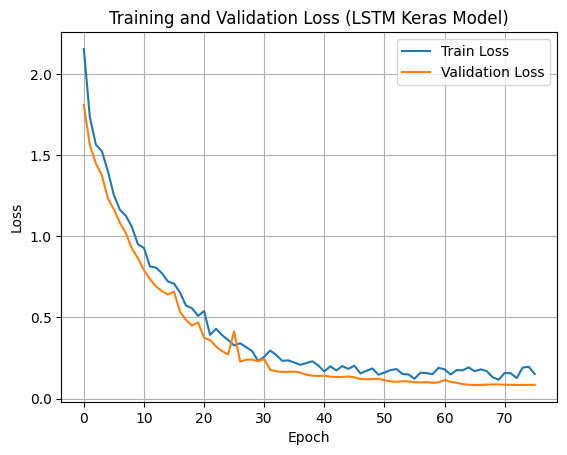

In [7]:

def main():
    input_dir = "C:\\Users\\Gen3r\\Documents\\capstone\\ml_model\\data\\data_2"

    # Step 1: Get data into frame
    dataframe, landmark_cols, landmark_world_cols = create_dataframe_from_data(input_dir)

    # Step 2: Split data into train test val sets
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(dataframe, "gesture")

    # Step 3: Feature Engineer
    isActive = True
    if os.path.exists("X_train_fe.csv") and isActive == True:
        X_train_fe = pd.read_csv("X_train_fe.csv")
        X_val_fe = pd.read_csv("X_val_fe.csv")
        X_test_fe = pd.read_csv("X_test_fe.csv")
        print("imported")
    else:
        X_train_fe = calculate_hand_motion_features(X_train, landmark_cols)
        X_val_fe = calculate_hand_motion_features(X_val, landmark_cols)
        X_test_fe = calculate_hand_motion_features(X_test, landmark_cols)

        X_train_fe.to_csv("model/LSTM/v2/X_train_fe.csv", index=False)
        X_val_fe.to_csv("model/LSTM/v2/X_val_fe.csv", index=False)
        X_test_fe.to_csv("model/LSTM/v2/X_test_fe.csv", index=False)
    
    # Step 4: Preprocessing 
    numerical_columns = ["frame_rate","frame_width","frame_height"]
    categorical_columns = ['hand', 'gesture_index']
    derived_features = ['elapsed_time'] + \
                [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk", "mean", "variance", "deviation", "skew", "kurt"] for col in landmark_cols] + \
                [f"lm_distance_{i}_{j}" for i in range(len(landmark_cols)//3) for j in range(len(landmark_cols)//3)] + \
                [f"angle_{n1}" for n1 in range(21)] + \
                ["score"]
    timeseries_columns = landmark_cols + landmark_world_cols + derived_features

    preprocessor = preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns)

    X_train_transformed = preprocessor.fit_transform(X_train_fe)
    X_val_transformed = preprocessor.transform(X_val_fe)
    X_test_transformed = preprocessor.transform(X_test_fe)

    y_train_reshaped = reshape_y_labels(y_train)
    y_val_reshaped = reshape_y_labels(y_val)
    y_test_reshaped = reshape_y_labels(y_test)


    label_encoder = LabelEncoder()
    combined_labels = pd.concat([y_train_reshaped, y_val_reshaped, y_test_reshaped])
    label_encoder.fit_transform(combined_labels)

    y_train_encoded = label_encoder.fit_transform(y_train_reshaped)
    y_val_encoded = label_encoder.fit_transform(y_val_reshaped)
    y_test_encoded = label_encoder.fit_transform(y_test_reshaped)
    


    print_shapes(X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test)

    
    X_train_padded, steps_len1, batch_size1, num_features = pad_dataframe(X_train_transformed)
    X_val_padded, steps_len2, batch_size2, num_features = pad_dataframe(X_val_transformed)
    X_test_padded, steps_len3, batch_size3, num_features = pad_dataframe(X_test_transformed)

    # print_shapes(X_train_padded, X_val_padded, X_test_padded)
    
    X_train_reshaped = np.reshape(X_train_padded, (batch_size1, steps_len1, num_features))
    X_val_reshaped = np.reshape(X_val_padded, (batch_size2, steps_len2, num_features))
    X_test_reshaped = np.reshape(X_test_padded, (batch_size3, steps_len3, num_features))

    
    print_shapes(X_train_reshaped, X_val_reshaped, X_test_reshaped, y_train_encoded, y_val_encoded, y_test_encoded)

    # tensorboard = TensorBoard(log_dir='./logs')	
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)	
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)	
    # model_checkpoint = ModelCheckpoint('model/LSTM/v2/best_model.keras', monitor='val_loss', save_best_only=True)
    
    input = (X_train_reshaped.shape[0], X_train_reshaped.shape[1], X_train_reshaped.shape[2])
    print(input)
    model = create_lstm(input, len(label_encoder.classes_))
    history = model.fit(	
        X_train_reshaped, y_train_encoded,	
        epochs=200,	
        batch_size=32,	
        validation_data=(X_val_reshaped, y_val_encoded),	
        callbacks=[early_stopping, reduce_lr]	
    )	

    test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_encoded)	
    print(f'Test Accuracy: {test_acc} || Test Loss: {test_loss}')

    # Extracting the history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    epochs = range(len(train_loss))  # Assuming loss recorded for each epoch

    # Plotting
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss (LSTM Keras Model)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def create_lstm(input_shape, output_units):
    model = Sequential()
    model.add(Masking(mask_value=-1))
    model.add(LSTM(units=64, input_shape=input_shape, kernel_regularizer=L1L2()))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_units, activation="softmax"))
    model.compile(optimizer=Adam(0.01), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model
main()

run 1: Test Accuracy: 0.9185185432434082 || Test Loss: 0.21805515885353088

    model = Sequential()
    model.add(Masking(mask_value=-1))
    model.add(LSTM(units=64, input_shape=input_shape, kernel_regularizer=L1L2()))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_units, activation="softmax"))
    model.compile(optimizer=Adam(0.01), loss="sparse_categorical_crossentropy", metrics=['accuracy'])